In [86]:
from PIL import Image
from diffusers import StableDiffusionImg2ImgPipeline
from pathlib import Path
from skimage import exposure
import numpy as np
import torch
import matplotlib.pyplot as plt
cuda = torch.device("cuda")

In [87]:
lora_weights_path = Path("../models/sd_lora/sd_lora_output")
model_id_or_path = "stabilityai/sd-turbo"

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id_or_path, torch_dtype=torch.float16)
pipe.load_lora_weights(lora_weights_path)
pipe = pipe.to(cuda)

# image_path = Path("/data/parietal/store3/work/pbarbara/data_augmentation_sonio/data/segmentations/684570.png")
image_path = Path("/data/parietal/store3/work/pbarbara/data_augmentation_sonio/data/segmentations/684741.png")
assert image_path.exists()

Loading pipeline components...: 100%|██████████| 5/5 [00:01<00:00,  4.37it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [88]:
def process_segmentation(image_path):
    '''Process the segmentation image to be used as input for the model.'''
    image = Image.open(image_path).resize((512, 512)).convert("L")

    # Invert the colors of the image
    image = Image.eval(image, lambda x: 255 - x)

    # Convert white to black
    image = Image.eval(image, lambda x: 0 if x == 255 else x)

    # Augment contrast
    image = Image.eval(image, lambda x: x * 1.5)

    # Convert to skimage
    img = np.array(image)

    # Contrast stretching
    p2, p98 = np.percentile(img, (2, 98))
    img = exposure.rescale_intensity(img, in_range=(p2, p98))

    image = Image.fromarray((img).astype(np.uint8)).convert("RGB")
    return image

init_image = process_segmentation(image_path)

In [91]:
prompt = "A healthy cardiac image from a Samsung ultrasound machine. The image should exhibit a lot of speckle noise like a real ultrasound echocardiography image. The shape of the cavities should tightly follow the segmentation mask."

# Do a grid search over the strength and guidance scale
strength, guidance_scale = [0.25, 0.5, 0.75], [1, 5, 5.25, 5.5, 5.75, 6, 7.5]
N = len(strength) * len(guidance_scale)
image_list = []
for s in strength:
    for g in guidance_scale:
        images = pipe(prompt=prompt, image=init_image, strength=s, guidance_scale=g, num_inference_steps=100).images
        image_list.append(images[0])

100%|██████████| 75/75 [00:05<00:00, 13.53it/s]


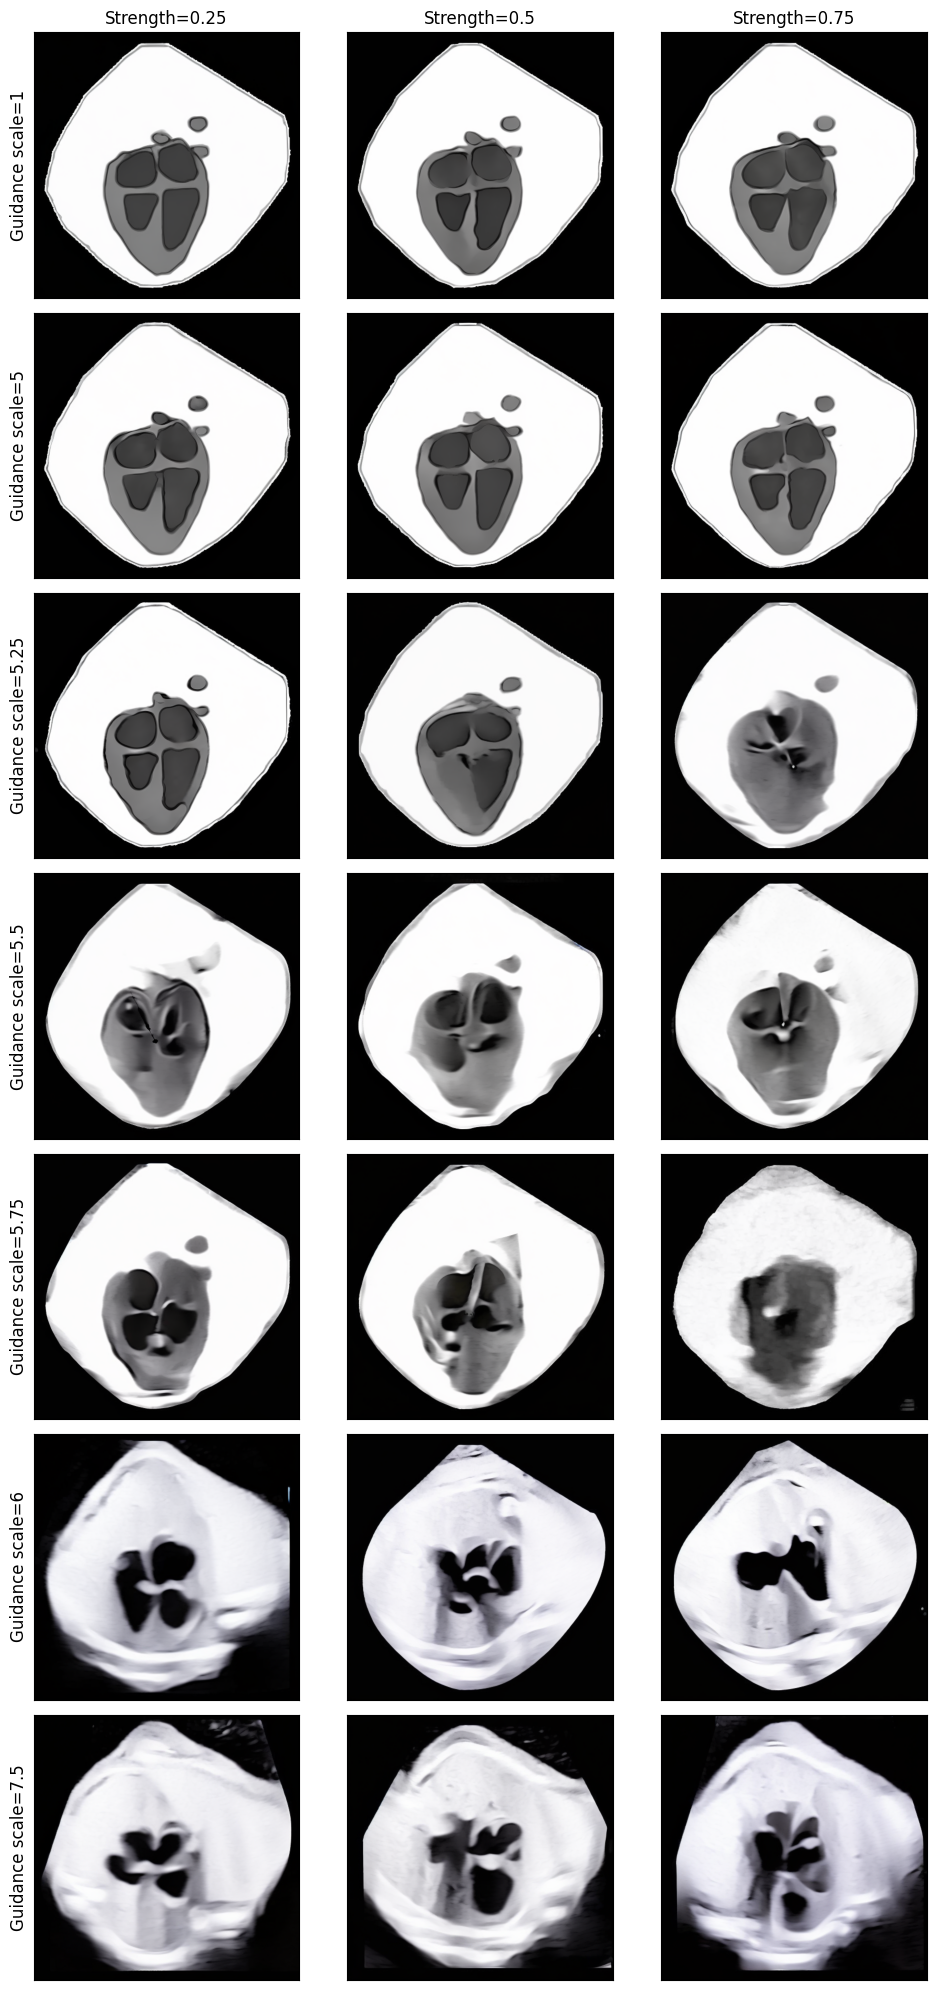

In [92]:
# Display the results on a grid
fig = plt.figure(figsize=(10, 20))
grid_spec = fig.add_gridspec(len(guidance_scale), len(strength))
for i, img in enumerate(image_list):
    ax = fig.add_subplot(grid_spec[i])
    ax.imshow(img)
    
    # Add labels
    if i % len(strength) == 0:
        ax.set_ylabel(
            f"Guidance scale={guidance_scale[i // len(strength)]}", 
            size="large",
        )
    if i < len(strength):
        ax.set_title(f"Strength={strength[i]}")
        
    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
plt.show()